### Generate subpanel Figure 2B

In [1]:
## import statements

from matplotlib import pyplot as plt
import seaborn as sns
import scanpy
import pandas
from typing import Tuple, Any, List, Union
import numpy as np
import torch
import os
from anndata import read_h5ad
from scanpy import pp
import pandas as pd
import scanpy as sc
from scipy import sparse
import anndata as Anndata
import random



# tissue_purifier import
import tissue_purifier as tp

In [2]:
from tissue_purifier.utils import *
from tissue_purifier.utils.anndata_util import *
from tissue_purifier.plots import *
from tissue_purifier.models.patch_analyzer import SpatialAutocorrelation, Composition
from tissue_purifier.data.dataset import MetadataCropperDataset
from tissue_purifier.plots.plot_misc import *

[neptune] [warning] NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.


In [3]:
from tissue_purifier.models.ssl_models._ssl_base_model import classify_and_regress
from sklearn.linear_model import RidgeClassifierCV, RidgeCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/skambha6/mini

In [4]:
## Make plots directory if it doesn't already exist
try:
    os.mkdir("./plots")
except:
    pass

### Load in data

In [5]:
## load in featurized anndatas

## path names
anndata_dest_folder = os.path.abspath('../TissueMosaic_output/thymus/thymus_split_xy_dm_annotated_spot_featurized/')


# Make a list of all the h5ad files in the annotated_anndata_dest_folder
fname_list = []
for f in os.listdir(anndata_dest_folder):
    if f.endswith('.h5ad'):
        fname_list.append(f)
print(fname_list)

anndata_list = []
for i,fname in enumerate(fname_list):
    anndata = read_h5ad(os.path.join(anndata_dest_folder, fname))
    anndata.obs['sample_id'] = i * np.ones(anndata.obs.shape[0])
    
    ## add log age as annotation
    ## add 1 since day 0 is an age
    anndata.obs['log_age'] = np.repeat(np.log1p(anndata.obs['Age'][0]), anndata.obs.shape[0])
    

    anndata.obs['classify_condition'] = anndata.obs['Age'].apply(lambda x: 'young' if x <= 35.0 else 'old')


    anndata_list.append(anndata)

['thymus_day_3.1_featurized.h5ad', 'thymus_week_48.1_featurized.h5ad', 'thymus_week_90.2_featurized.h5ad', 'thymus_day_13.1_featurized.h5ad', 'thymus_week_4.3_featurized.h5ad', 'thymus_day_13.2_featurized.h5ad', 'thymus_day_4.2_featurized.h5ad', 'thymus_day_3.2_featurized.h5ad', 'thymus_week_13.2_featurized.h5ad', 'thymus_week_90.1_featurized.h5ad', 'thymus_day_2.2_featurized.h5ad', 'thymus_day_1.1_featurized.h5ad', 'thymus_week_28.2_featurized.h5ad', 'thymus_week_3.1_featurized.h5ad', 'thymus_day_1.2_featurized.h5ad', 'thymus_week_4.2_featurized.h5ad', 'thymus_week_13.1_featurized.h5ad', 'thymus_week_5.3_featurized.h5ad', 'thymus_week_68.1_featurized.h5ad', 'thymus_day_2.3_featurized.h5ad', 'thymus_week_9.2_featurized.h5ad', 'thymus_day_10.2_featurized.h5ad', 'thymus_week_3.2_featurized.h5ad', 'thymus_week_5.1_featurized.h5ad', 'thymus_week_48.2_featurized.h5ad', 'thymus_day_3.3_featurized.h5ad', 'thymus_week_68.3_featurized.h5ad', 'thymus_day_0.1_featurized.h5ad', 'thymus_day_10.1_fe

In [12]:
## Load in anndatas with cortex_medulla information

anndata_dest_folder_cm=os.path.abspath('../TissueMosaic_data/thymus_anndata')

# Make a list of all the h5ad files in the annotated_anndata_dest_folder
fname_list_cm = []
for f in os.listdir(anndata_dest_folder_cm):
    if f.endswith('.h5ad'):
        fname_list_cm.append(f)
print(fname_list_cm)

anndata_list_cm = []
for i,fname in enumerate(fname_list_cm):
    anndata = read_h5ad(os.path.join(anndata_dest_folder_cm, fname))

    anndata_list_cm.append(anndata)


# Function to strip '_featurized' and '.h5ad' from the filenames
def strip_filename(filename):
    return filename.replace('_featurized', '').replace('.h5ad', '')

# Add cortex/medulla information to featurized anndatas
for i, file in enumerate(fname_list):
    # Strip the filename
    stripped_file = strip_filename(file)

    # Add back the original file extension to match with the first list
    stripped_file_with_ext = stripped_file + '.h5ad'

    # Check if the stripped filename is in the original files list and find its index
    if stripped_file_with_ext in fname_list_cm:
        index = fname_list_cm.index(stripped_file_with_ext)
        
        anndata_list[i].obs['cortex_medulla'] = anndata_list_cm[index].obs['cortex_medulla']




['thymus_week_7.2.h5ad', 'thymus_week_4.3.h5ad', 'thymus_day_2.2.h5ad', 'thymus_day_7.2.h5ad', 'thymus_week_3.2.h5ad', 'thymus_week_68.3.h5ad', 'thymus_day_4.2.h5ad', 'thymus_day_0.1.h5ad', 'thymus_day_1.2.h5ad', 'thymus_day_1.1.h5ad', 'thymus_week_68.1.h5ad', 'thymus_day_3.2.h5ad', 'thymus_day_3.1.h5ad', 'thymus_week_90.1.h5ad', 'thymus_week_9.2.h5ad', 'thymus_week_9.1.h5ad', 'thymus_week_15.2.h5ad', 'thymus_day_3.3.h5ad', 'thymus_week_28.2.h5ad', 'thymus_week_68.2.h5ad', 'thymus_week_32.3.h5ad', 'thymus_week_13.1.h5ad', 'thymus_day_2.1.h5ad', 'thymus_week_5.2.h5ad', 'thymus_day_7.1.h5ad', 'thymus_week_32.1.h5ad', 'thymus_day_4.1.h5ad', 'thymus_week_28.1.h5ad', 'thymus_day_10.1.h5ad', 'thymus_week_48.1.h5ad', 'thymus_week_5.3.h5ad', 'thymus_week_4.2.h5ad', 'thymus_week_90.2.h5ad', 'thymus_week_7.1.h5ad', 'thymus_week_32.2.h5ad', 'thymus_day_10.2.h5ad', 'thymus_day_5.2.h5ad', 'thymus_week_15.1.h5ad', 'thymus_day_2.3.h5ad', 'thymus_week_3.1.h5ad', 'thymus_day_5.1.h5ad', 'thymus_week_48.

In [13]:
## check scale factors
print(3000/(np.max(anndata_list[35].obs['x_val']) - np.min(anndata_list[35].obs['x_val'])))
print(3000/(np.max(anndata_list[35].obs['y_val']) - np.min(anndata_list[35].obs['y_val'])))

0.6583567415730337
0.7132328467500357


### Plotting

In [14]:
## plotting parameters

linewidth = 7
tickfontsize = 80
labelfontsize = 80
labelpad = 50
titlefontsize=80
legendfontsize=80

In [15]:
# prop_cycle = plt.rcParams['axes.prop_cycle']
# colors = prop_cycle.by_key()['color']

colors = sns.color_palette("deep", 10).as_hex()

# assign color to cell type
cdict = {
    'APC': colors[0],
    'CD4+T': colors[4],
    'CD8+T': colors[3],
    'DC': colors[5],
    'DN': colors[6],
    'DP': colors[1],
    'Effector Lymphocytes': colors[2],
    'Other stroma': colors[7],
    'TEC': colors[8]
}

In [16]:
merged_anndata = merge_anndatas_inner_join(anndata_list)
adata = merged_anndata
adata

AnnData object with n_obs × n_vars = 1255473 × 4432
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'Age', 'Batch', 'Cell_type', 'Cell_type2', 'Spot_class', 'Junction', 'x_val', 'y_val', 'dino_spot_features_valid', 'train_test_fold_1', 'train_test_fold_2', 'train_test_fold_3', 'train_test_fold_4', 'sample_id', 'log_age', 'classify_condition', 'cortex_medulla'
    uns: 'sparse_image_state_dict'
    obsm: 'cell_grouping_proportions', 'cell_type_proportions', 'dino_spot_features', 'doublet_weights', 'ncv_k100', 'ncv_k25', 'ncv_k500'

## Run conditional motif enrichment

In [17]:
## add majority cell grouping to obs
adata.obs['Cell_grouping'] = adata.obsm['cell_grouping_proportions'].idxmax(axis=1)

In [18]:
### Filtering ###

## filter out outlier features in spots
adata.obsm['dino_spot_features'][adata.obsm['dino_spot_features'] > 3.0] = 0

adata_all = adata
## filter to cell type of interest (apc)
adata_apc = adata[adata.obs['Cell_grouping'] == 'APC']
adata = adata_apc

In [19]:
adata

View of AnnData object with n_obs × n_vars = 16097 × 4432
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'Age', 'Batch', 'Cell_type', 'Cell_type2', 'Spot_class', 'Junction', 'x_val', 'y_val', 'dino_spot_features_valid', 'train_test_fold_1', 'train_test_fold_2', 'train_test_fold_3', 'train_test_fold_4', 'sample_id', 'log_age', 'classify_condition', 'cortex_medulla', 'Cell_grouping'
    uns: 'sparse_image_state_dict'
    obsm: 'cell_grouping_proportions', 'cell_type_proportions', 'dino_spot_features', 'doublet_weights', 'ncv_k100', 'ncv_k25', 'ncv_k500'

In [20]:
# Train regressor to predict age from features

feature_key = "dino_spot_features"

all_folds_test_anndata = []
for kfold in range(1,5):

    ## spatial split
    train_anndata = adata[adata.obs[f'train_test_fold_{kfold}'] == 0]
    test_anndata = adata[adata.obs[f'train_test_fold_{kfold}'] == 1]


    regressor = RidgeCV(alphas=[1000.0, 2500.0, 5000.0])
    regressor.fit(train_anndata.obsm[feature_key], train_anndata.obs['log_age'])
    print(f"Kfold: {kfold}")
    print(regressor.score(test_anndata.obsm[feature_key], test_anndata.obs['log_age']))
    predicted_log_age = regressor.predict(test_anndata.obsm[feature_key])

    test_anndata.obs['predicted_log_age'] = predicted_log_age
    
    all_folds_test_anndata.append(test_anndata)

    print("alpha:")
    print(regressor.alpha_)

merged_anndata = merge_anndatas_inner_join(all_folds_test_anndata)

Kfold: 1
0.4934009521009505
alpha:
1000.0
Kfold: 2


/tmp/ipykernel_4016695/2437823188.py:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  test_anndata.obs['predicted_log_age'] = predicted_log_age
/tmp/ipykernel_4016695/2437823188.py:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  test_anndata.obs['predicted_log_age'] = predicted_log_age


0.32008685391590164
alpha:
1000.0
Kfold: 3
0.3005237493726878
alpha:
1000.0
Kfold: 4
0.4033376493066366


/tmp/ipykernel_4016695/2437823188.py:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  test_anndata.obs['predicted_log_age'] = predicted_log_age
/tmp/ipykernel_4016695/2437823188.py:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  test_anndata.obs['predicted_log_age'] = predicted_log_age


alpha:
1000.0


In [21]:
## only keep spots that have cortex/medulla annotation assigned to them

merged_anndata.obs['cortex_medulla'] = merged_anndata.obs['cortex_medulla'].astype(str) 
np.unique(merged_anndata.obs['cortex_medulla'])

merged_anndata_filtered = merged_anndata[merged_anndata.obs['cortex_medulla'] != "nan"]

In [22]:
merged_anndata_filtered

View of AnnData object with n_obs × n_vars = 15169 × 4432
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'Age', 'Batch', 'Cell_type', 'Cell_type2', 'Spot_class', 'Junction', 'x_val', 'y_val', 'dino_spot_features_valid', 'train_test_fold_1', 'train_test_fold_2', 'train_test_fold_3', 'train_test_fold_4', 'sample_id', 'log_age', 'classify_condition', 'cortex_medulla', 'Cell_grouping', 'predicted_log_age'
    uns: 'sparse_image_state_dict'
    obsm: 'cell_grouping_proportions', 'cell_type_proportions', 'dino_spot_features', 'doublet_weights', 'ncv_k100', 'ncv_k25', 'ncv_k500'

## Figure 2B

In [23]:
ages = []

for anndata in anndata_list:
    ages.append(np.array(anndata.obs['log_age'])[0])

ages = np.unique(ages)
print(ages)

age_apc_clustering = {}

for age in ages:
    # age_apc_clustering[str(age)] = []
    merged_anndata_filtered_age = merged_anndata_filtered[merged_anndata_filtered.obs['log_age'] == age]
    age_apc_clustering[age] = merged_anndata_filtered_age.obsm['ncv_k100'][:,0]
age_apc = age_apc_clustering


[0.         0.69314718 1.09861229 1.38629436 1.60943791 1.79175947
 2.07944154 2.39789527 2.63905733 3.09104245 3.36729583 3.58351894
 3.91202301 4.15888308 4.52178858 4.66343909 5.28320373 5.4161004
 5.82008293 6.16751649 6.44730586]


In [24]:
## Bin APC clustering based on distilled age and plot

apc_clustering = np.array(merged_anndata_filtered.obsm['ncv_k100'][:,0])
distilled_age = merged_anndata_filtered.obs['predicted_log_age']
distilled_age[np.where(distilled_age > 7)[0]] = 7
distilled_age[np.where(distilled_age < 0)[0]] = 0


x = distilled_age
y = apc_clustering

num_bins = 8
# Bin the x-axis values
bins = np.linspace(min(x), max(x), num_bins) 
bin_indices = np.digitize(x, bins)

# Round each value to 4 decimal places
formatted_bins = [round(num, 1) for num in bins]

# Aggregate the y-axis values based on the binning
binned_y = [y[bin_indices == i] for i in range(1, len(bins))]

/tmp/ipykernel_4016695/962435454.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distilled_age[np.where(distilled_age > 7)[0]] = 7
/tmp/ipykernel_4016695/962435454.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distilled_age[np.where(distilled_age < 0)[0]] = 0


In [25]:
# sort age_apc dictionary by age

sorted_keys = sorted(age_apc.keys(), key=float)

# sort apc arrays by age
sorted_arrays = [age_apc[key] for key in sorted_keys]

## group true apc age scores into same bins defined for distilled age

digitized_indices = np.digitize(sorted_keys, bins[1:])

binned_arrays = []
for i in range(1,len(bins)):
    binned_arrays.append([])

for i, age in enumerate(sorted_arrays):
    binned_arrays[digitized_indices[i]].append(age)
    
for i in range(len(binned_arrays)):
    binned_arrays[i] = np.concatenate(binned_arrays[i])    

In [26]:
## plotting parameters

linewidth = 7
tickfontsize = 100
labelfontsize = 150
labelpad = 60
titlefontsize=150
legendfontsize=150

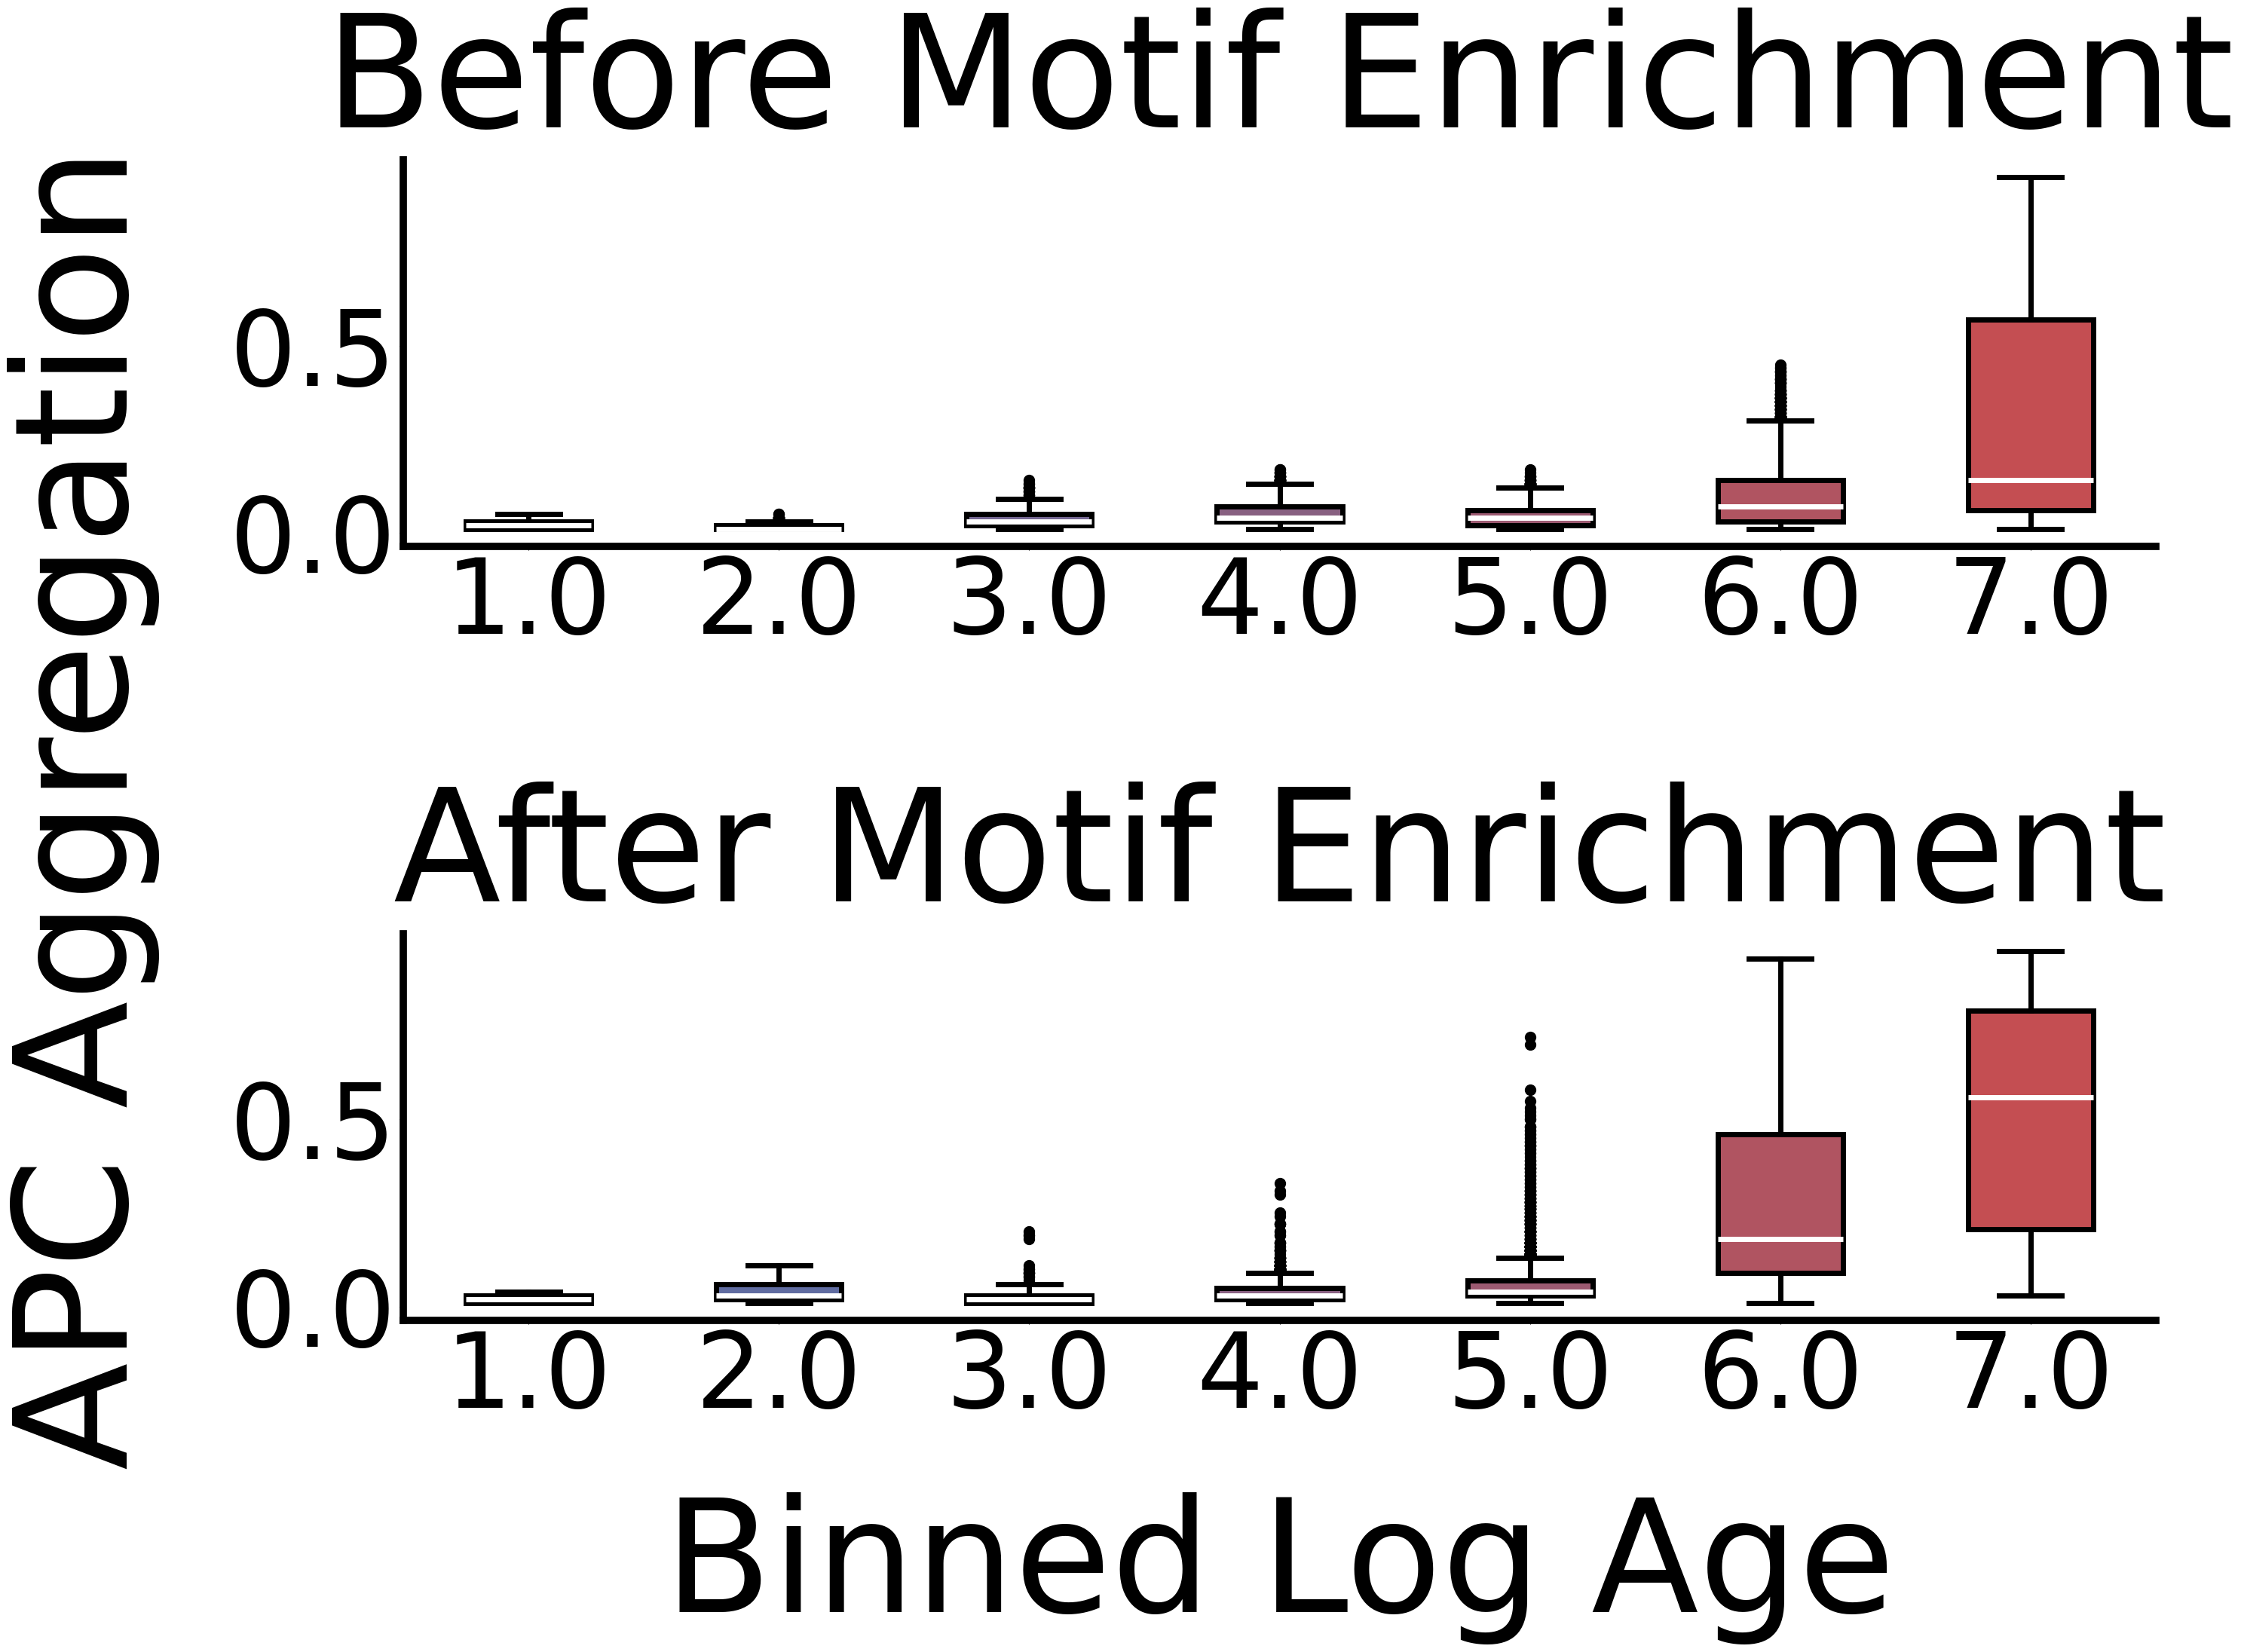

In [27]:
## Create matplotlib gridspec of 2 x 1 and plot two box plots into each grid

# Create the gridspec
fig = plt.figure(figsize=(30,20))
gs = fig.add_gridspec(2, 1)

boxplot_linewidth = 5
# Plot the second box plot in the second grid
ax1 = fig.add_subplot(gs[0, 0])
bp = ax1.boxplot(binned_arrays,patch_artist=True,flierprops={'marker': 'o', 'markerfacecolor':'black', 'markersize': 10.0}, 
                 boxprops={'linewidth': boxplot_linewidth},
                 whiskerprops={'linewidth': boxplot_linewidth},
                 capprops={'linewidth': boxplot_linewidth},
                 medianprops={'linewidth': boxplot_linewidth, 'color': 'white'})

# Rasterize the the fliers in the boxplot
for component in ['fliers']:
    for item in bp[component]:
        item.set_rasterized(True)

from matplotlib.colors import LinearSegmentedColormap

# Define a linear gradient from blue to red
cmap = LinearSegmentedColormap.from_list('blue_to_red', [colors[0], colors[3]])
num_boxes = len(bp['boxes'])
for i, box in enumerate(bp['boxes']):
    color = cmap(i / (num_boxes - 1))
    box.set_facecolor(color)
    box.set_edgecolor('black')  # Optional: set the edge color of the box

# ax1.set_xlabel('Binned Log Age', fontsize=labelfontsize, labelpad=labelpad)
ax1.set_xticks(np.arange(num_bins-1)+1, formatted_bins[1:], fontsize=tickfontsize)
# ax1.set_ylabel('APC Clustering', fontsize=labelfontsize, labelpad=labelpad)
ax1.set_title('Before Motif Enrichment', fontsize=titlefontsize)
ax1.yaxis.set_tick_params(labelsize=tickfontsize)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth(linewidth)
ax1.spines['left'].set_linewidth(linewidth)



# Plot the first box plot in the first grid
ax2 = fig.add_subplot(gs[1, 0])
bp = ax2.boxplot(binned_y,patch_artist=True,flierprops={'marker': 'o', 'markerfacecolor':'black', 'markersize': 10.0},
                 boxprops={'linewidth': boxplot_linewidth},
                 whiskerprops={'linewidth': boxplot_linewidth},
                 capprops={'linewidth': boxplot_linewidth},
                 medianprops={'linewidth': boxplot_linewidth, 'color': 'white'})

# Rasterize the the fliers in the boxplot
for component in ['fliers']:
    for item in bp[component]:
        item.set_rasterized(True)

# Define a linear gradient from blue to red
cmap = LinearSegmentedColormap.from_list('blue_to_red', [colors[0], colors[3]])
num_boxes = len(bp['boxes'])
for i, box in enumerate(bp['boxes']):
    color = cmap(i / (num_boxes - 1))
    box.set_facecolor(color)
    box.set_edgecolor('black')  # Optional: set the edge color of the box

ax2.set_xlabel('Binned Log Age', fontsize=titlefontsize, labelpad=labelpad)
ax2.set_xticks(np.arange(num_bins-1)+1, formatted_bins[1:], fontsize=tickfontsize)
# ax2.set_ylabel('APC Clustering', fontsize=labelfontsize, labelpad=labelpad)
ax2.set_title('After Motif Enrichment', fontsize=titlefontsize)
ax2.yaxis.set_tick_params(labelsize=tickfontsize)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_linewidth(linewidth)
ax2.spines['left'].set_linewidth(linewidth)

# Set a common y-label for both subplots
fig.text(-0.05, 0.45, 'APC Aggregation', va='center', rotation='vertical', fontsize=titlefontsize)

# Set the horizontal space between the subplots
plt.subplots_adjust(hspace=1.0)

# Show the plot
fig.savefig('./plots/fig_2b.pdf', transparent=True, bbox_inches='tight',dpi=600)



In [28]:
print("before purification:")
for tp in binned_arrays:
    print(tp.shape)

print("after purification:")
for tp in binned_y:
    print(tp.shape)

before purification:
(247,)
(280,)
(699,)
(4077,)
(2052,)
(3546,)
(4268,)
after purification:
(13,)
(34,)
(109,)
(2088,)
(8713,)
(3279,)
(928,)


## Figure 2C

In [29]:
labelfontsize = 60

/tmp/ipykernel_4016695/2091880165.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  samples_of_interest = [int(np.where(np.array(fname_list) == "thymus_week_5.1_featurized.h5ad")[0]),
/tmp/ipykernel_4016695/2091880165.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  int(np.where(np.array(fname_list) == "thymus_week_32.1_featurized.h5ad")[0]),
/tmp/ipykernel_4016695/2091880165.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  int(np.where(np.array(fname_list)

/tmp/ipykernel_4016695/2091880165.py:71: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  merged_anndata_sample.obs['cell_type'] = merged_anndata.obsm['cell_grouping_proportions'].idxmax(axis=1)
/tmp/ipykernel_4016695/2091880165.py:91: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  gene_adata.obs[gene] = genex


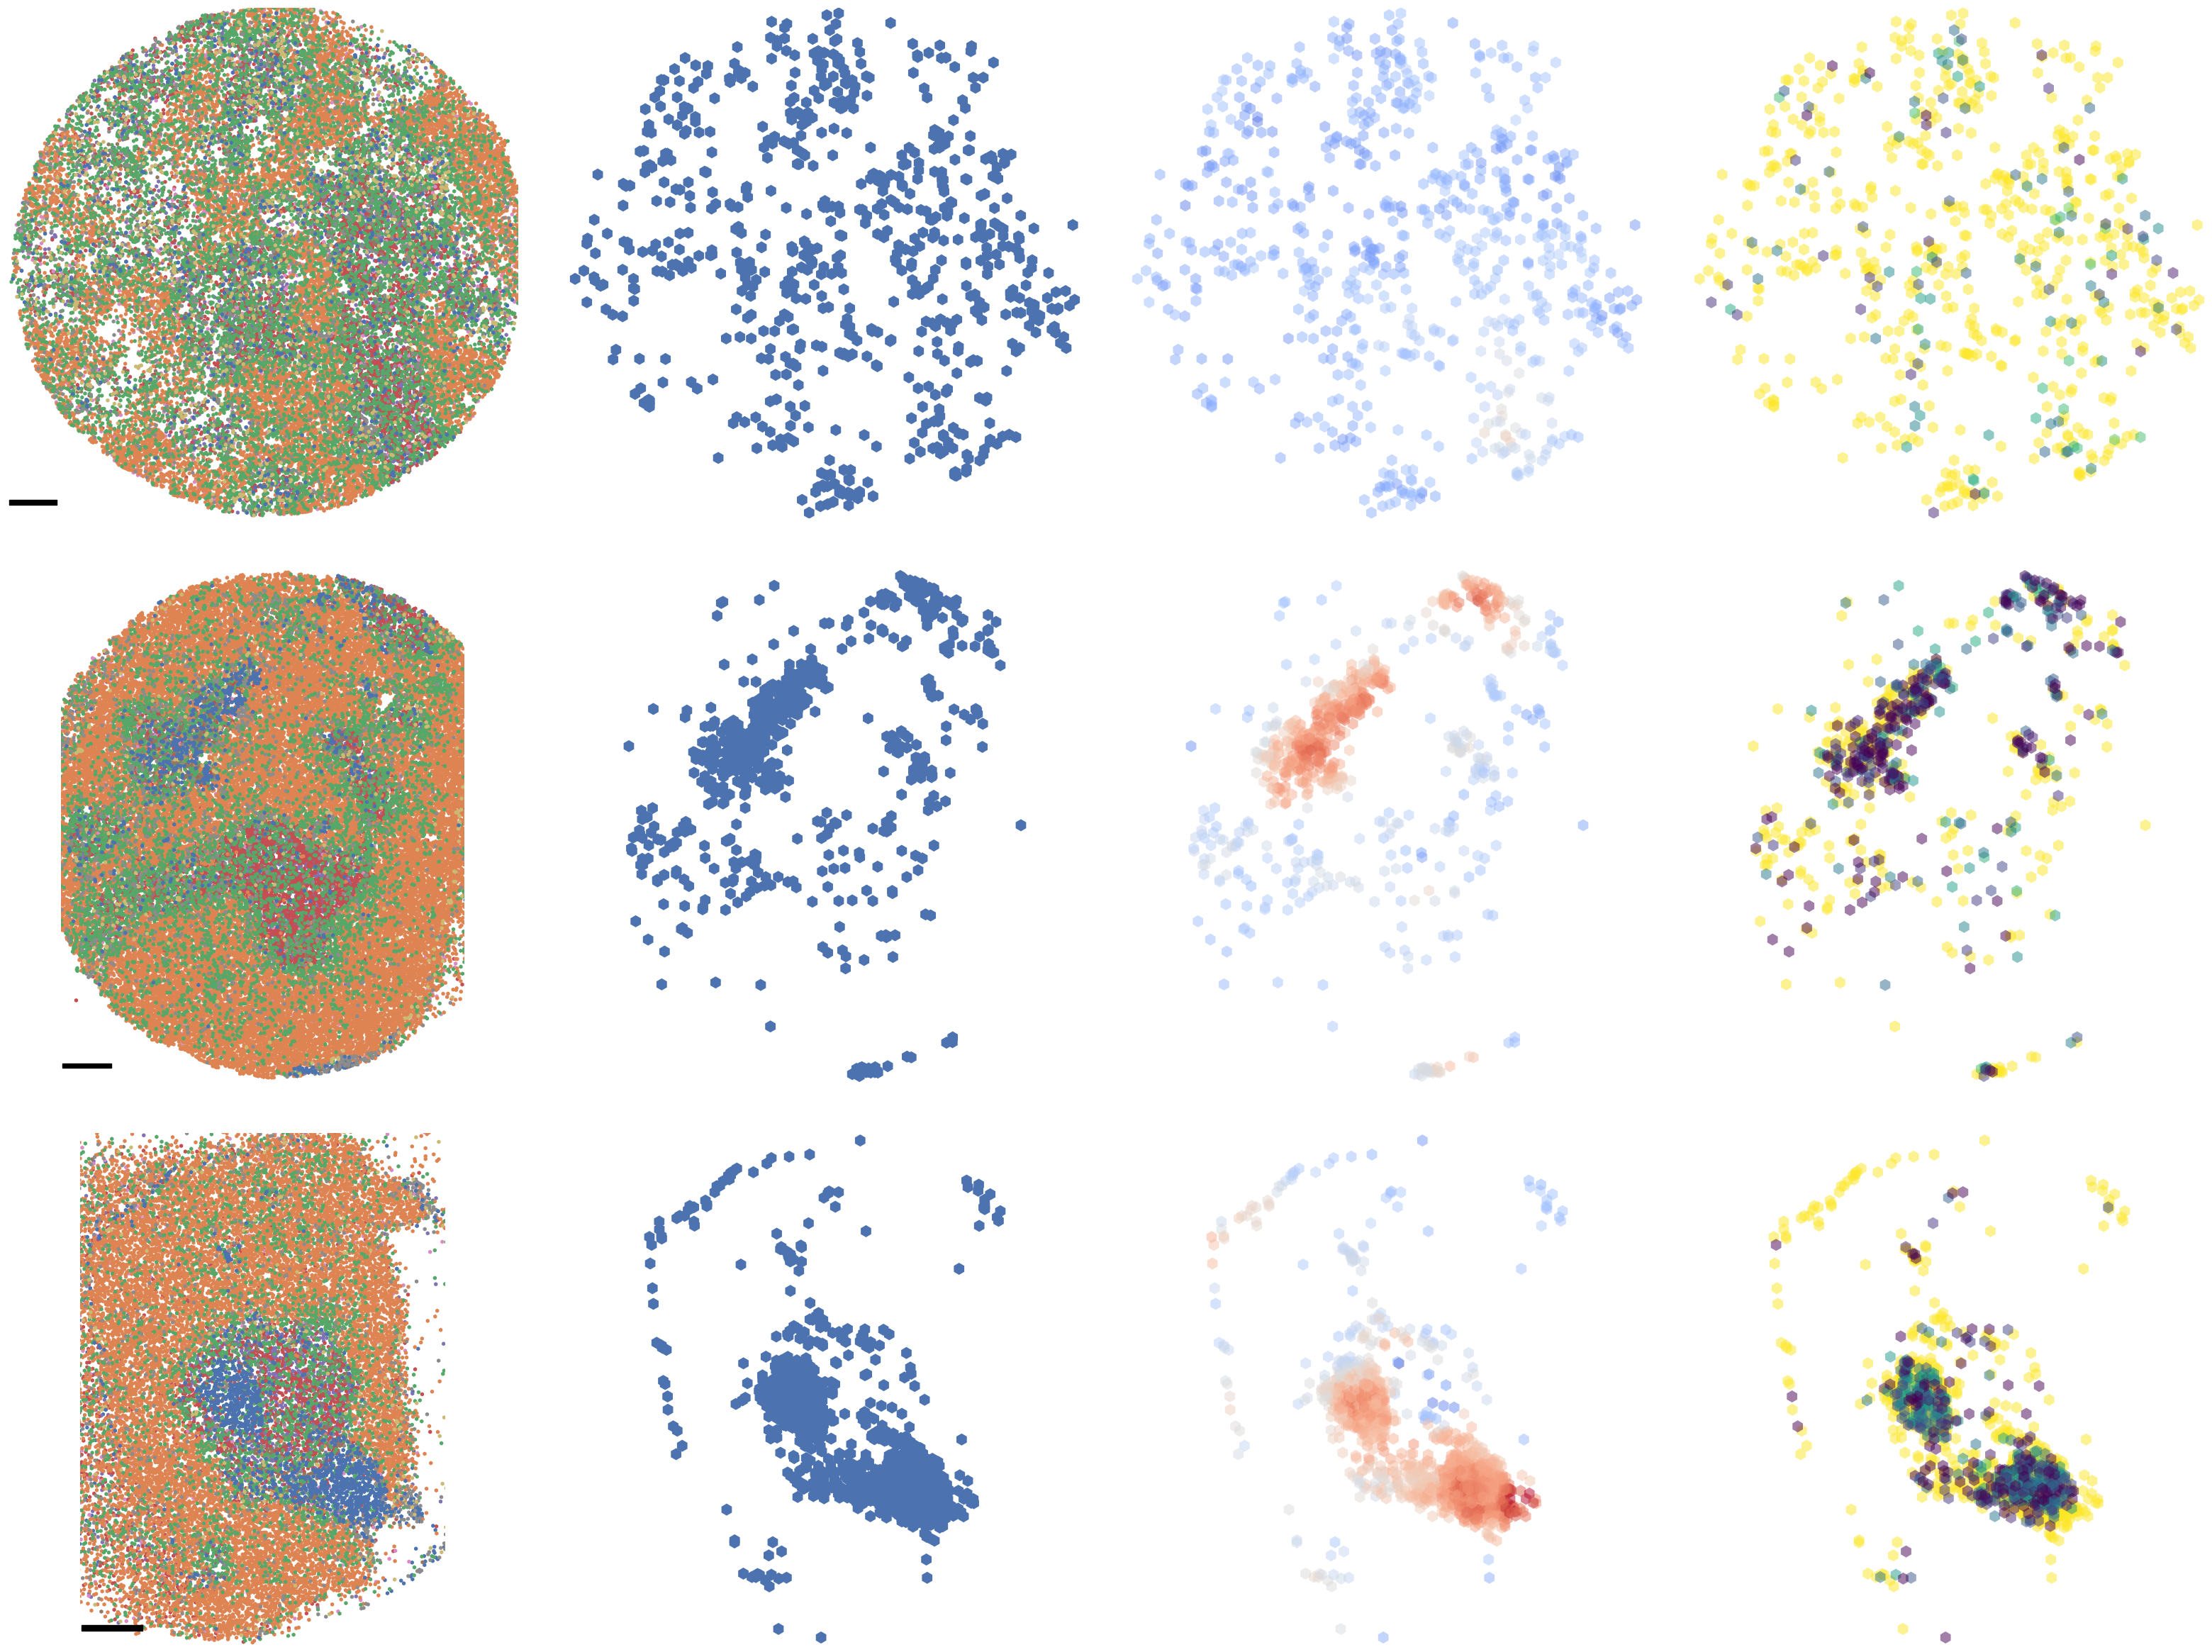

In [30]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

samples_of_interest = [int(np.where(np.array(fname_list) == "thymus_week_5.1_featurized.h5ad")[0]), 
                       int(np.where(np.array(fname_list) == "thymus_week_32.1_featurized.h5ad")[0]),
                        int(np.where(np.array(fname_list) == "thymus_week_90.1_featurized.h5ad")[0])]


gene = 'Cd74'

week5 = merged_anndata_filtered[merged_anndata_filtered.obs['sample_id'] == samples_of_interest[0]]
week32 = merged_anndata_filtered[merged_anndata_filtered.obs['sample_id'] == samples_of_interest[1]]
week90 = merged_anndata_filtered[merged_anndata_filtered.obs['sample_id'] == samples_of_interest[2]]
adata_list = [week5, week32, week90]

week5_all = adata_all[adata_all.obs['sample_id'] == samples_of_interest[0]]
week32_all = adata_all[adata_all.obs['sample_id'] == samples_of_interest[1]]
week90_all = adata_all[adata_all.obs['sample_id'] == samples_of_interest[2]]
adata_all_list = [week5_all, week32_all, week90_all]

alpha = 0.5



for adata in adata_list:
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)

## cell types in one grid-spec


fig = plt.figure(figsize=(40, 30))
plt.grid(False)
plt.axis('off')
gs = fig.add_gridspec(3,4)
s1 = 150
s2 = 150


age_labels = ['Week 5', 'Week 32', 'Week 90']
# hue_neg, hue_pos = 250, 15
# cmap = sns.diverging_palette(hue_neg, hue_pos, center="dark", as_cmap=True)
cmap = sns.color_palette("coolwarm", as_cmap=True)
for k, i in enumerate(samples_of_interest):

  

    # fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 4))
    merged_anndata_sample = merged_anndata_filtered[merged_anndata_filtered.obs['sample_id'] == i]

    if merged_anndata_sample.obs.shape[0] > 0:

        scatter_pad = 50
        xlim = (np.min(merged_anndata_sample.obs['y_val'])-scatter_pad , np.max(merged_anndata_sample.obs['y_val'])+scatter_pad )
        ylim = (np.min(merged_anndata_sample.obs['x_val'])-scatter_pad , np.max(merged_anndata_sample.obs['x_val'])+scatter_pad )


        ax0 = fig.add_subplot(gs[k, 0])
        scatter(adata_all_list[k], 'Cell_grouping', mode="categorical", x_key="y_val", y_key="x_val", show_legend=False,s = s2/8,cdict=cdict, fig=fig, ax=ax0, x_lim = xlim, y_lim = ylim, rasterized=True)
        ## plot apcs on top
        scatter(merged_anndata_sample, 'Cell_grouping', mode="categorical", x_key="y_val", y_key="x_val", show_legend=False,s = s2/8,cdict=cdict, fig=fig, ax=ax0, x_lim = xlim, y_lim = ylim, rasterized=True)
        scalebar = AnchoredSizeBar(ax0.transData,
                           410.96, '', 'lower left', 
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=40)
        ax0.add_artist(scalebar)    


        ## plot cell types in space
        merged_anndata_sample.obs['cell_type'] = merged_anndata.obsm['cell_grouping_proportions'].idxmax(axis=1)
        
        ax1 = fig.add_subplot(gs[k, 1])
        scatter(merged_anndata_sample, 'cell_type', mode="categorical", x_key="y_val", y_key="x_val", show_legend=False,s = s2,cdict=cdict, fig=fig, ax=ax1, x_lim = xlim, y_lim = ylim, rasterized=True)


        ax2 = fig.add_subplot(gs[k, 2])

        scatter(merged_anndata_sample, 'predicted_log_age', x_key="y_val", y_key="x_val", s = s2,fig=fig,ax = ax2, vmin=3,vmax=7, cmap=cmap, show_colorbar=False, alpha=alpha, x_lim=xlim, y_lim=ylim, rasterized=True) #, legend_fontsize=tickfontsize, colorbar_fontsize=tickfontsize)
        
        ## plot regressor score in space
        ax3 = fig.add_subplot(gs[k, 3])
        
        adata = adata_list[k]
        x_coord = adata.obs['x_val']
        y_coord = adata.obs['y_val']
        
        gene_adata = adata[:,gene]
        
        genex = np.squeeze(np.array(gene_adata.X.todense().flatten()))
        gene_adata.obs[gene] = genex
        
        
        gene_adata_subset_1 = gene_adata[np.where(genex == 0)[0]]
        gene_adata_subset_2 = gene_adata[np.where(genex > 0)[0]]
        ## plot cd74 gene expression in space
        scatter(gene_adata_subset_1, gene, x_key="y_val", y_key="x_val", s = s1,fig=fig,ax = ax3, cmap='viridis_r', vmin=0, vmax=1.0, show_colorbar=False, x_lim = xlim, y_lim=ylim, alpha=alpha, rasterized=True) #, legend_fontsize=tickfontsize, colorbar_fontsize=tickfontsize, zorder=0)
        ## plot cd74 gene expression > 0 on top
        scatter(gene_adata_subset_2, gene, x_key="y_val", y_key="x_val", s = s1,fig=fig,ax = ax3, cmap='viridis_r', vmin=0, vmax=1.0, show_colorbar=False, x_lim=xlim, y_lim = ylim, alpha=alpha, rasterized=True) #, legend_fontsize=tickfontsize, colorbar_fontsize=tickfontsize, zorder=1)
        


plt.subplots_adjust(hspace=0.1)
plt.subplots_adjust(wspace=0.1)

fig.savefig('./plots/fig_2c.pdf', transparent=True, bbox_inches='tight',dpi=600)

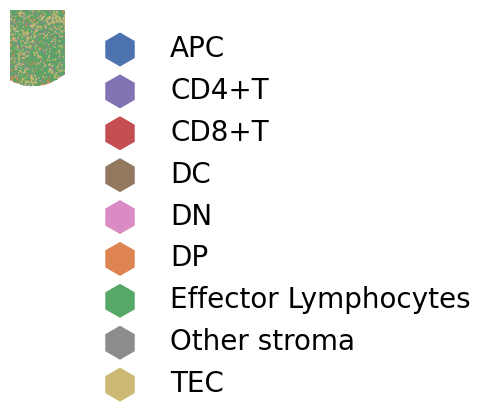

In [31]:
fig, ax = plt.subplots(figsize=(9,1))

s = s1
scatter(adata_all_list[0], 'Cell_grouping', mode="categorical", x_key="y_val", y_key="x_val", show_legend=True,s = s/100,cdict=cdict, fig=fig, ax=ax, x_lim = xlim, y_lim = ylim, rasterized=True)
fig.savefig('./plots/thymus_legend.pdf', transparent=True, bbox_inches='tight',dpi=600)

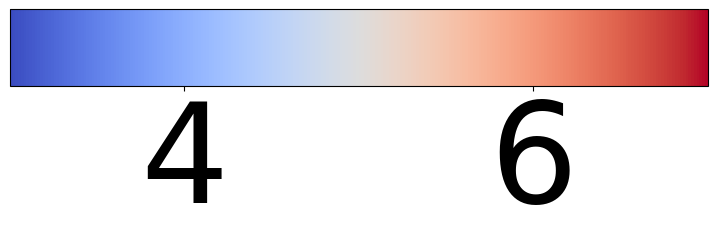

In [32]:
# plt.colorbar(sc, ax=ax, label=None, fraction=0.046, pad=0.04)
norm = plt.Normalize(vmin=3, vmax=7)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

fig, ax = plt.subplots(figsize=(9,1))
    
cbar = plt.colorbar(sm, orientation='horizontal', cax=ax)
ax.tick_params(labelsize=tickfontsize)
fig.savefig('./plots/fig_2c_colorbar1.pdf', transparent=True, bbox_inches='tight',dpi=600)

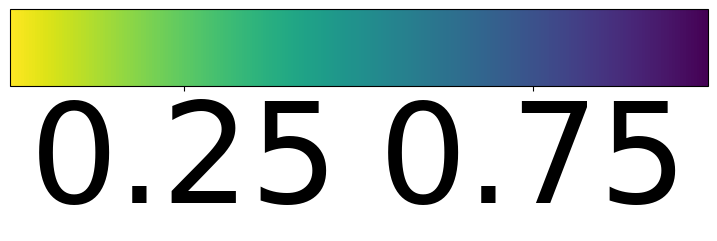

In [33]:
sm = plt.cm.ScalarMappable(cmap='viridis_r')
fig, ax = plt.subplots(figsize=(9,1))
cbar = plt.colorbar(sm, cax=ax, orientation='horizontal')
cbar.set_ticks([0.25, 0.75])
cbar.set_ticklabels([0.25, 0.75])
ax.tick_params(labelsize=tickfontsize)
fig.savefig('./plots/fig_2c_colorbar2.pdf', transparent=True, bbox_inches='tight',dpi=600)

### Generate Figure 2D

In [34]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

In [35]:
## functions to pseudobulk and aggregate anndata

def pseudobulk_anndata(adata, group_by='sample_id', new_obs=None):

    # Grouping by sample_id
    groupby_object = merged_anndata_filtered.obs.groupby([group_by], observed=True)

    # Initialize variables
    X = merged_anndata_filtered.X
    N_obs = groupby_object.ngroups
    
    print(N_obs)
    
    N_var = X.shape[1]
    X_summed = sparse.lil_matrix((N_obs, N_var))

    # Summing expression data
    group_names = []
    index_names = []
    row = 0
    for group_name, indices in groupby_object.indices.items():
        X_summed[row] = X[indices].sum(0)
        row += 1
        group_names.append(group_name)
        index_names.append(str(group_name))

    # Convert to appropriate sparse format
    if sparse.isspmatrix_csr(X):
        X_summed = X_summed.tocsr()
    else:
        X_summed = np.array(X_summed.todense())

    if new_obs is not None:
        # Creating new obs DataFrame
        obs = pd.DataFrame(new_obs, index=index_names)
    else:
        # Creating new obs DataFrame
        obs = pd.DataFrame(index=index_names)

    # Creating new AnnData object
    new_adata = AnnData(X=X_summed, obs=obs, var=merged_anndata_filtered.var)

    return new_adata

NUM_OF_CELL_PER_DONOR = 1


def aggregate_and_filter(
    adata,
    cell_identity,
    donor_key="sample_id",
    condition_key="label",
    cell_identity_key="Cell_grouping",
    obs_to_keep=[],  # which additional metadata to keep, e.g. gender, age, etc.
    replicates_per_patient=1,
):
    # subset adata to the given cell identity
    adata_cell_pop = adata[adata.obs[cell_identity_key] == cell_identity].copy()
    # check which donors to keep according to the number of cells specified with NUM_OF_CELL_PER_DONOR
    size_by_donor = adata_cell_pop.obs.groupby([donor_key]).size()
    donors_to_drop = [
        donor
        for donor in size_by_donor.index
        if size_by_donor[donor] <= NUM_OF_CELL_PER_DONOR
    ]
    if len(donors_to_drop) > 0:
        print("Dropping the following samples:")
        print(donors_to_drop)
    df = pd.DataFrame(columns=[*adata_cell_pop.var_names, *obs_to_keep])

    adata_cell_pop.obs[donor_key] = adata_cell_pop.obs[donor_key].astype("category")
    for i, donor in enumerate(donors := adata_cell_pop.obs[donor_key].cat.categories):
        print(f"\tProcessing donor {i+1} out of {len(donors)}...", end="\r")
        if donor not in donors_to_drop:
            adata_donor = adata_cell_pop[adata_cell_pop.obs[donor_key] == donor]
            # create replicates for each donor
            indices = list(adata_donor.obs_names)
            random.shuffle(indices)
            indices = np.array_split(np.array(indices), replicates_per_patient)
            for i, rep_idx in enumerate(indices):
                adata_replicate = adata_donor[rep_idx]
                # specify how to aggregate: sum gene expression for each gene for each donor and also keep the condition information
                agg_dict = {gene: "sum" for gene in adata_replicate.var_names}
                for obs in obs_to_keep:
                    agg_dict[obs] = "first"
                # create a df with all genes, donor and condition info
                df_donor = pd.DataFrame(adata_replicate.X.A)
                df_donor.index = adata_replicate.obs_names
                df_donor.columns = adata_replicate.var_names
                df_donor = df_donor.join(adata_replicate.obs[obs_to_keep])
                # aggregate
                df_donor = df_donor.groupby(donor_key).agg(agg_dict)
                df_donor[donor_key] = donor
                df.loc[f"donor_{donor}_{i}"] = df_donor.loc[donor]
    print("\n")
    # create AnnData object from the df
    adata_cell_pop = sc.AnnData(
        df[adata_cell_pop.var_names], obs=df.drop(columns=adata_cell_pop.var_names)
    )
    return adata_cell_pop


In [36]:
## pseudobulk and aggregate anndata

cell_type_de = 'APC'
cell_type_de_key = 'Cell_grouping'

merged_anndata_filtered_distilled_young = merged_anndata_filtered[merged_anndata_filtered.obs['predicted_log_age'] < 5.0]
merged_anndata_filtered_distilled_old = merged_anndata_filtered[merged_anndata_filtered.obs['predicted_log_age'] >= 5.0]

merged_anndata_filtered_young_pseudobulked = aggregate_and_filter(merged_anndata_filtered_distilled_young, cell_type_de, obs_to_keep=['sample_id', 'Age', 'classify_condition', 'Cell_type', 'Cell_grouping'],
                                                                     cell_identity_key = cell_type_de_key)

merged_anndata_filtered_old_pseudobulked = aggregate_and_filter(merged_anndata_filtered_distilled_old, cell_type_de, obs_to_keep=['sample_id', 'Age', 'Cell_type', 'classify_condition', 'Cell_grouping'],
                                                               cell_identity_key = cell_type_de_key)

merged_anndata_filtered_combined = merge_anndatas_inner_join([merged_anndata_filtered_old_pseudobulked,merged_anndata_filtered_young_pseudobulked]) 

	Processing donor 45 out of 45...

Dropping the following samples:
[15.0, 27.0]
	Processing donor 24 out of 24...



/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [37]:
## pre-process data

counts_df = pd.DataFrame(merged_anndata_filtered_combined.X)
counts_df.columns = np.array(merged_anndata_filtered_combined.var.index)
counts_df.index = np.array(merged_anndata_filtered_combined.obs.index)
metadata = merged_anndata_filtered_combined.obs

In [38]:
## run DESeq2py

inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design_factors="classify_condition",  # compare samples based on the "condition"
    # column ("B" vs "A")
    refit_cooks=True,
    inference=inference,
)

dds.fit_size_factors()

dds.obsm["size_factors"]

dds.fit_genewise_dispersions()

dds.varm["genewise_dispersions"]

dds.fit_dispersion_trend()
# dds.uns["trend_coeffs"]
dds.varm["fitted_dispersions"]

dds.fit_dispersion_prior()
print(
    f"logres_prior={dds.uns['_squared_logres']}, sigma_prior={dds.uns['prior_disp_var']}"
)

dds.fit_MAP_dispersions()
dds.varm["MAP_dispersions"]
dds.varm["dispersions"]

dds.fit_LFC()
dds.varm["LFC"]

dds.calculate_cooks()
if dds.refit_cooks:
    # Replace outlier counts
    dds.refit()
    
stat_res = DeseqStats(dds, alpha=0.05, cooks_filter=True, independent_filter=True)
stat_res.run_wald_test()

stat_res._p_value_adjustment()


stat_res.padj
stat_res.summary()

/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_4016695/1169196326.py:4: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.33 seconds.

Fitting dispersion trend curve...
... done in 0.06 seconds.

Fitting MAP dispersions...


logres_prior=0.5323132609757799, sigma_prior=0.5010658032387263


... done in 0.33 seconds.

Fitting LFCs...
... done in 0.25 seconds.

/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
Replacing 2 outlier genes.

/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: classify-condition young vs old
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
4930523C07Rik  2.409562       -0.094402  0.264125 -0.357414  0.720782   
AB124611       0.664823        0.577486  0.400186  1.443044  0.149008   
Abhd17b        1.464268       -0.930383  0.352600 -2.638639  0.008324   
Acp5           8.211094        0.264042  0.181435  1.455303  0.145585   
Add3           5.080412        0.147859  0.188519  0.784319  0.432853   
...                 ...             ...       ...       ...       ...   
Neurod1        0.000000             NaN       NaN       NaN       NaN   
Mab21l2        0.000000             NaN       NaN       NaN       NaN   
Cd79a          0.408359        0.338524  0.680130  0.497735  0.618671   
Fcnb           0.048113        0.693375  1.618434  0.428423  0.668343   
Klra3          0.029288        0.895622  1.790766  0.500133  0.616981   

                   padj  
4930523C07Rik  0.860194  
A

... done in 0.21 seconds.



In [39]:
## plotting parameters

linewidth = 5
tickfontsize = 80
labelfontsize = 80
labelpad = 60
titlefontsize=80
legendfontsize=80

In [40]:

de_results = stat_res.results_df
de_results['log2FoldChange'] = de_results['log2FoldChange'] * -1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


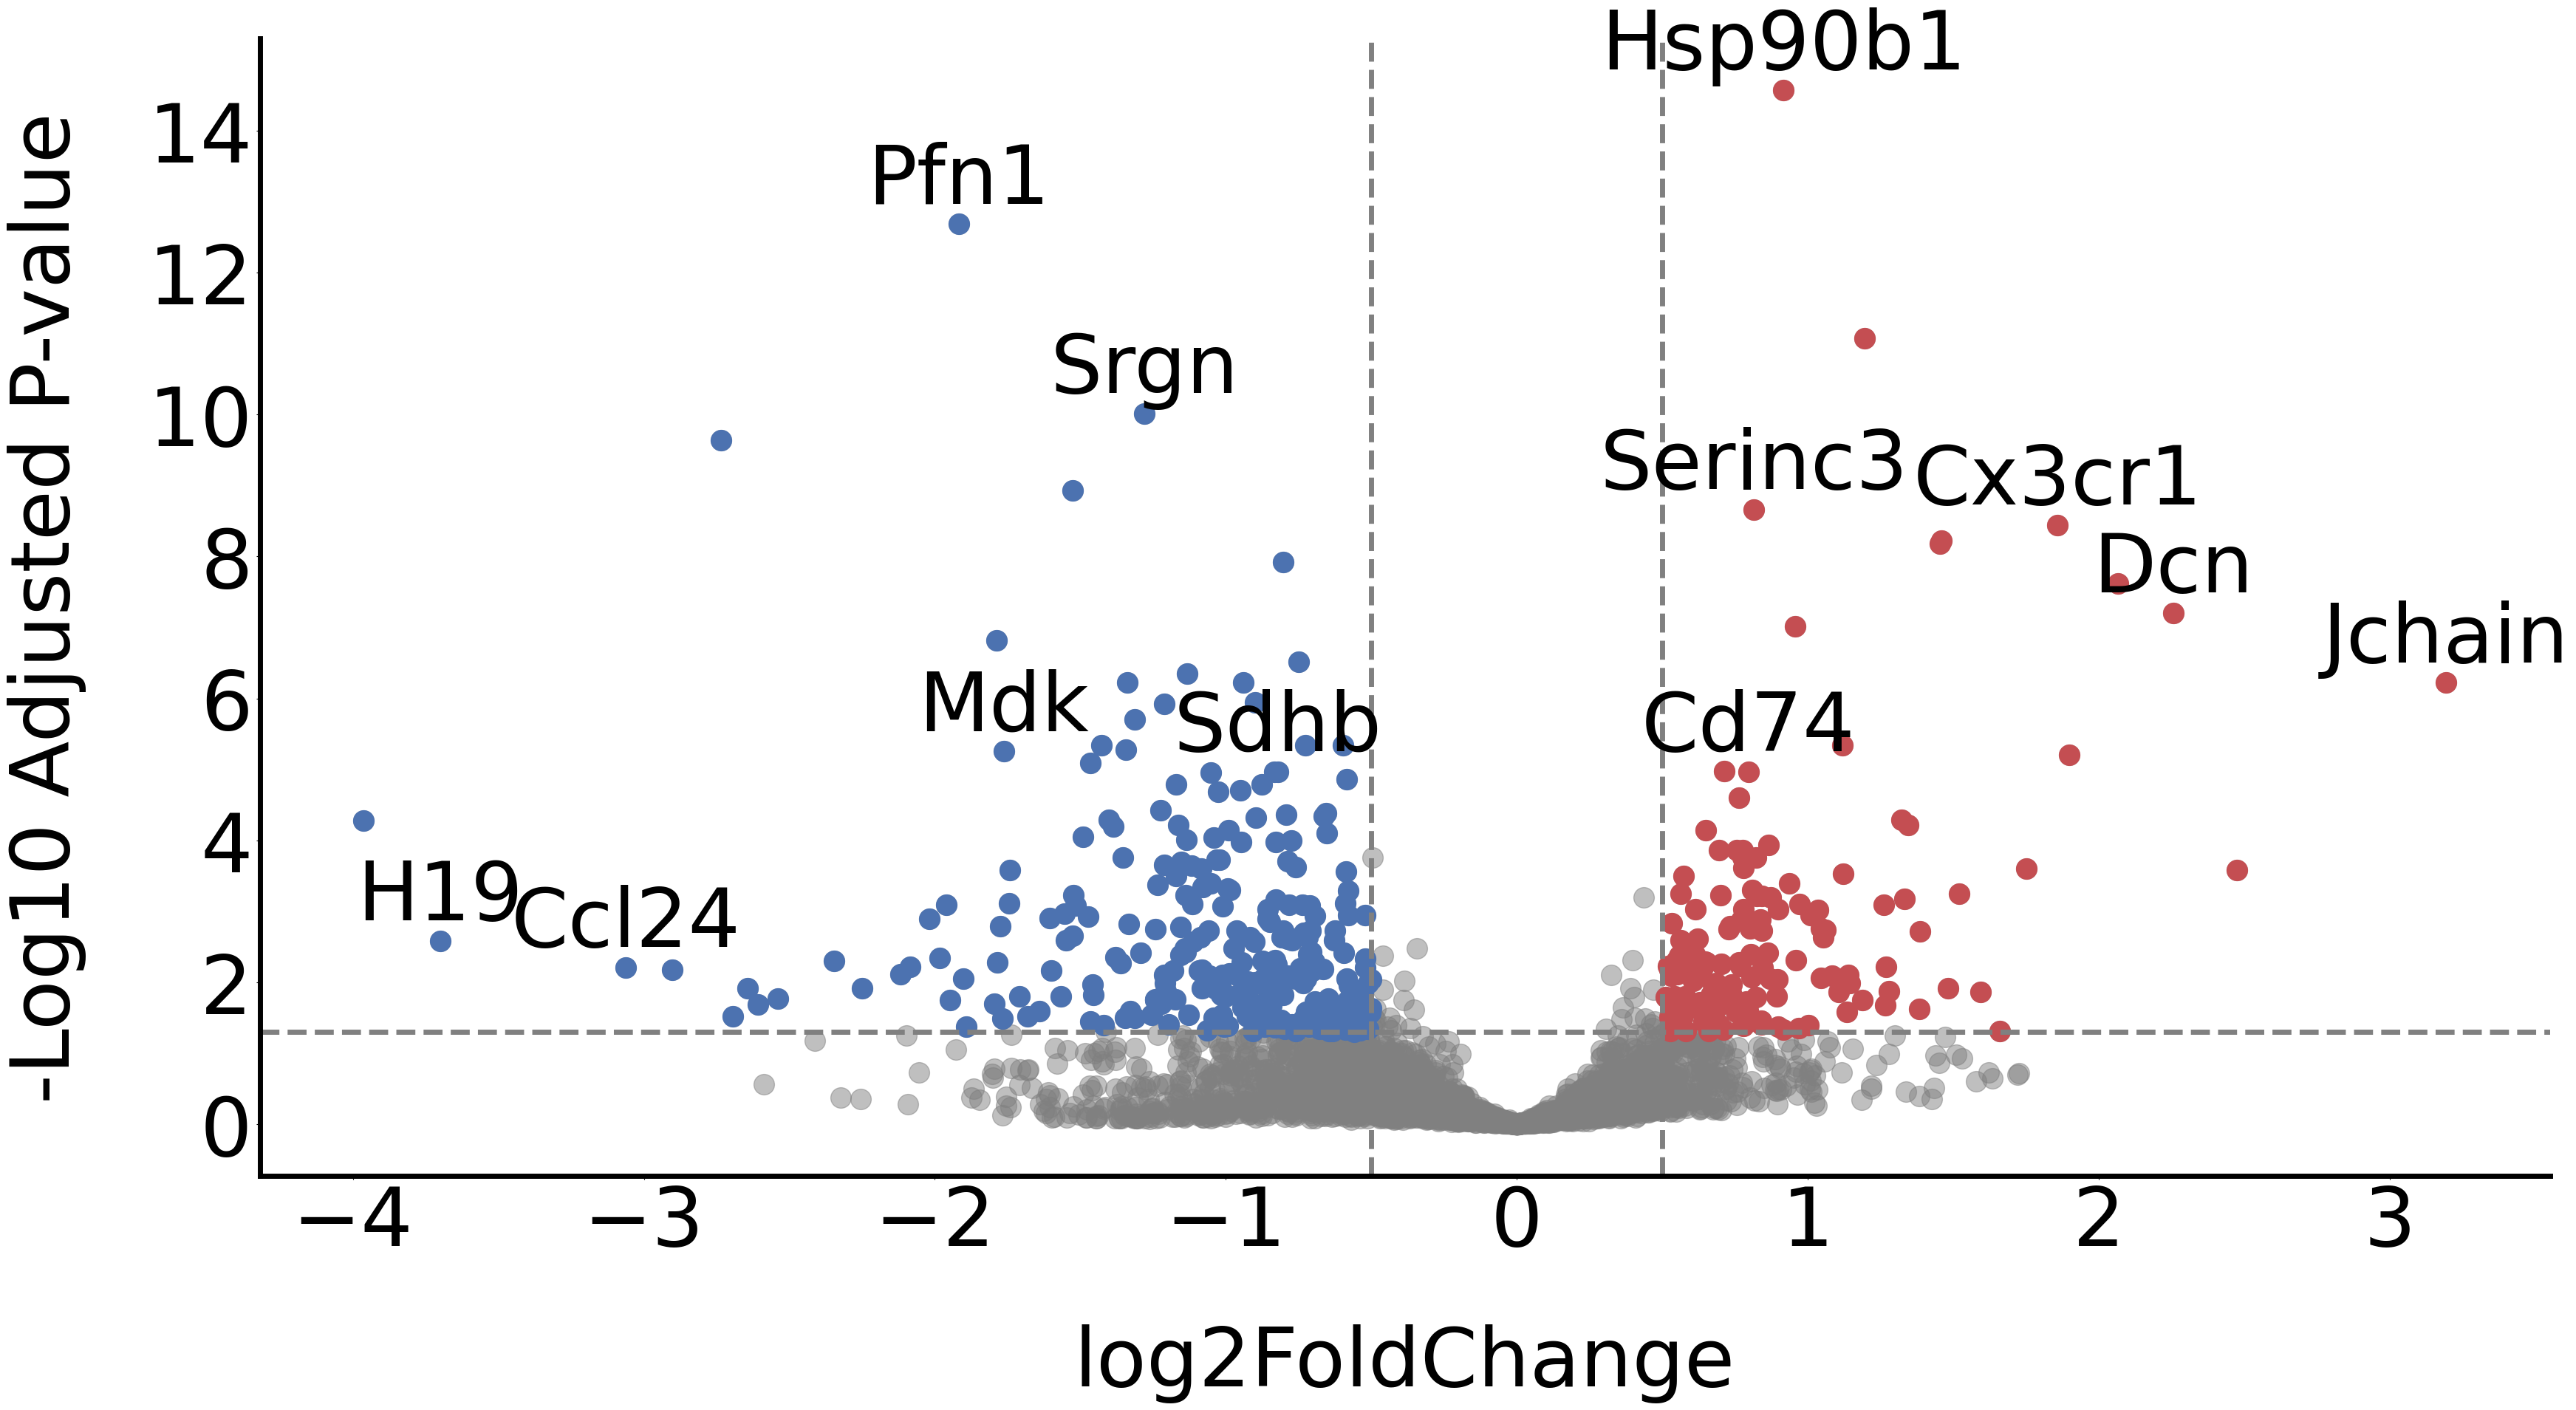

In [41]:
# Filter out genes with no significant differential expression and log fold change greater than 1.0

de_results_up_filtered = de_results[(de_results['padj'] < 0.05) & (de_results['log2FoldChange'] > 0.5)]

de_results_down_filtered = de_results[(de_results['padj'] < 0.05) & (de_results['log2FoldChange'] < -0.5)]


de_results_filtered = de_results[(de_results['padj'] < 0.05) & (abs(de_results['log2FoldChange']) > 0.5)]

s = 400

# Create a volcano plot
fig, ax = plt.subplots(figsize=(40, 20))

plt.scatter(
    de_results['log2FoldChange'],
    -np.log10(de_results['padj']),
    color='grey',
    alpha=0.5,
    s = s,
    # label='Others'
)

plt.scatter(
    de_results_up_filtered['log2FoldChange'],
    -np.log10(de_results_up_filtered['padj']),
    color=colors[3],
    s=s,
    # label='padj < 0.05\n|LogFC| > 0.5'
)

plt.scatter(
    de_results_down_filtered['log2FoldChange'],
    -np.log10(de_results_down_filtered['padj']),
    color=colors[0],
    s=s,
    # label='padj < 0.05\n|LogFC| > 0.5'
)


# # Annotate each significant gene with its name
# for i, row in de_results_filtered.iterrows():
#     if -np.log10(row['padj']) > 5.5:
#         plt.text(row['log2FoldChange'], -np.log10(row['padj']) + 0.1, np.array(row.name), fontsize=legendfontsize, ha='center')
#     if row['log2FoldChange'] > 3 and -np.log10(row['padj']) > 1:
#         plt.text(row['log2FoldChange'], -np.log10(row['padj']) + 0.1, np.array(row.name), fontsize=legendfontsize, ha='center')
#     if row['log2FoldChange'] < -1.5 and -np.log10(row['padj']) > 3:
#         plt.text(row['log2FoldChange'], -np.log10(row['padj']) + 0.1, np.array(row.name), fontsize=legendfontsize, ha='center')
#     if row['log2FoldChange'] > 1.5 and -np.log10(row['padj']) > 4:
#         plt.text(row['log2FoldChange'], -np.log10(row['padj']) + 0.1, np.array(row.name), fontsize=legendfontsize, ha='center')

## annotate specific genes
genes_to_annotate = ['Cd74', 'Jchain', 'Cx3cr1', 'Cxcl1', 'Serinc3', 'Pfn1', 'Hsp90b1', 'Dcn',
                     'Sdhb', 'H19', 'Ccl24', 'Srgn', 'Mdk'] # Igf2bp3
for i, row in de_results_filtered.iterrows():
    if row.name in genes_to_annotate:
        plt.text(row['log2FoldChange'], -np.log10(row['padj']) + 0.3, np.array(row.name), fontsize=legendfontsize, ha='center')

        

plt.xlabel('log2FoldChange', labelpad=labelpad, fontsize=labelfontsize)
plt.ylabel('-Log10 Adjusted P-value', labelpad=labelpad, fontsize=labelfontsize)
plt.xticks(fontsize=tickfontsize)
plt.yticks(fontsize=tickfontsize)
plt.legend(frameon=False, fontsize=legendfontsize, handlelength=0.0, markerscale=2.0, loc='upper right', bbox_to_anchor=(1.02, 1.05))



ax.axhline(y=1.3, linestyle='--', color='grey', linewidth=linewidth)
ax.axvline(x=0.5, linestyle='--', color='grey', linewidth=linewidth)
ax.axvline(x=-0.5, linestyle='--', color='grey', linewidth=linewidth)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(linewidth)
ax.spines['left'].set_linewidth(linewidth)
fig.savefig('./plots/fig_2d.pdf', transparent=True, bbox_inches='tight',dpi=600)

2024-06-26 15:26:58,106 [INFO] Parsing data files for GSEA.............................
2024-06-26 15:26:58,261 [INFO] 9763 gene_sets have been filtered out when max_size=1000 and min_size=10
2024-06-26 15:26:58,262 [INFO] 0797 gene_sets used for further statistical testing.....
2024-06-26 15:26:58,263 [INFO] Start to run GSEA...Might take a while..................


(4432, 6)


2024-06-26 15:27:05,747 [INFO] Congratulations. GSEApy runs successfully................



                                                 Term       NES NOM p-val  \
0   GOBP_POSITIVE_REGULATION_OF_EPITHELIAL_CELL_PR...  2.160453       0.0   
6                  GOBP_ACTIVATION_OF_IMMUNE_RESPONSE -1.993773   0.00227   
2    GOBP_REGULATION_OF_EPITHELIAL_CELL_PROLIFERATION  2.079427  0.000962   
15                     GOMF_GLYCOSAMINOGLYCAN_BINDING -1.879324  0.006833   
5               GOCC_EXTERNAL_SIDE_OF_PLASMA_MEMBRANE -2.003521  0.004348   
14                             GOBP_B_CELL_ACTIVATION  -1.88895  0.007933   
11                               GOBP_CELL_ACTIVATION -1.908463  0.001328   
10                       GOBP_CYTOPLASMIC_TRANSLATION -1.930038  0.006018   
22                            GOCC_CYTOSOLIC_RIBOSOME -1.836179  0.011255   
4         GOCC_INTRINSIC_COMPONENT_OF_PLASMA_MEMBRANE -2.022395  0.003626   
7                          GOBP_NEUTROPHIL_CHEMOTAXIS  1.984596    0.0016   
8                           GOBP_NEUTROPHIL_MIGRATION  1.984596    0.0016   

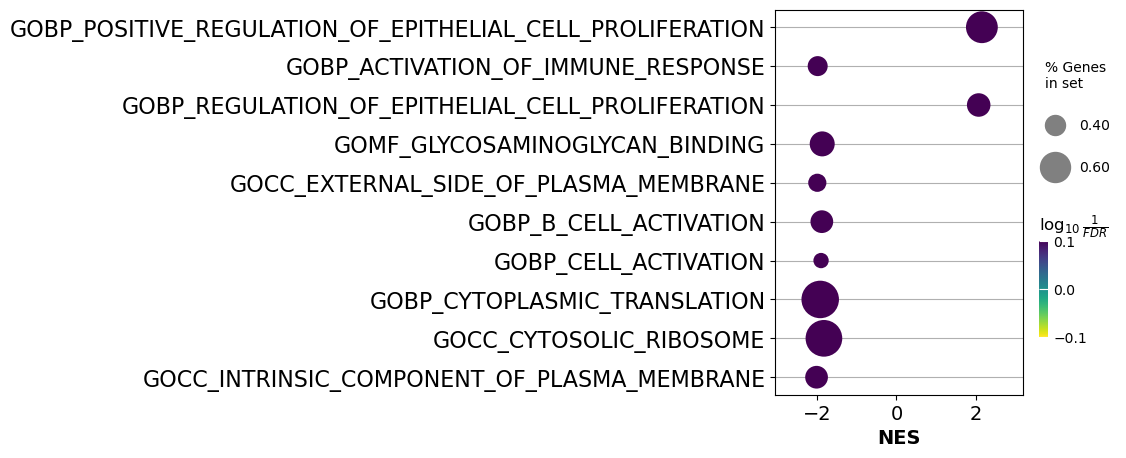

In [42]:
## GSEA

import gseapy as gp
from gseapy import dotplot

de_results = stat_res.results_df
de_results['log2FoldChange'] = de_results['log2FoldChange'] * -1
de_results_filtered = de_results[(de_results['padj'] < 0.05)]

print(de_results.shape)

# prerank = de_results_filtered.sort_values(by='log2FoldChange')['log2FoldChange']
prerank = de_results_filtered.sort_values(by='log2FoldChange')['log2FoldChange']
pre_res = gp.prerank(rnk=prerank, # or rnk = rnk,
                     gene_sets='/home/skambha6/chenlab/utils/m5.go.v2022.1.Mm.symbols.gmt', ## replace this path with the path to your gmt file 
                     threads=4,
                     min_size=10,
                     max_size=1000,
                     permutation_num=10000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )

# pre_res.res2d.sort_values(by='NOM p-val', ascending = True, inplace=True)
pre_res.res2d.sort_values(by='FDR q-val', ascending = True, inplace=True)
print(pre_res.res2d.head(15)[['Term', 'NES', 'NOM p-val', 'FDR q-val', 'Lead_genes']]) 

ax = dotplot(pre_res.res2d,
             column="FDR q-val",
             cmap=plt.cm.viridis_r,
             size=6, # adjust dot size
             figsize=(4,5), thresh=0.25, cutoff=0.25, show_ring=False,
             ofname=None)

pre_res_filter = pre_res.res2d[pre_res.res2d['FDR q-val'] < 0.25]
pre_res_filter[['Term', 'NES', 'NOM p-val', 'FDR q-val', 'Lead_genes']].to_csv('purification_thymus_spatial_de_gsea.csv')